# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block8_10_conv', 'conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8376 - accuracy: 0.7228

947/947 [==============================] - 5716s 6s/step - loss: 0.8376 - accuracy: 0.7228 - val_loss: 1.0240 - val_accuracy: 0.6512
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7208 - accuracy: 0.7525

947/947 [==============================] - 5279s 6s/step - loss: 0.7208 - accuracy: 0.7525 - val_loss: 0.7399 - val_accuracy: 0.7321
Epoch 3/200
947/947 [==============================] - 4840s 5s/step - loss: 0.6696 - accuracy: 0.7702 - val_loss: 0.7521 - val_accuracy: 0.7641
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6469 - accuracy: 0.7755

947/947 [==============================] - 5221s 6s/step - loss: 0.6469 - accuracy: 0.7755 - val_loss: 0.5997 - val_accuracy: 0.7945
Epoch 5/200
947/947 [==============================] - 4835s 5s/step - loss: 0.6152 - accuracy: 0.7871 - val_loss: 0.6775 - val_accuracy: 0.7472
Epoch 6/200
947/947 [==============================] - 4837s 5s/step - loss: 0.5955 - accuracy: 0.7912 - val_loss: 0.6549 - val_accuracy: 0.7780
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.7991

947/947 [==============================] - 5256s 6s/step - loss: 0.5737 - accuracy: 0.7991 - val_loss: 0.5895 - val_accuracy: 0.7899
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5457 - accuracy: 0.8070

947/947 [==============================] - 5328s 6s/step - loss: 0.5457 - accuracy: 0.8070 - val_loss: 0.5427 - val_accuracy: 0.8094
Epoch 9/200
947/947 [==============================] - 4873s 5s/step - loss: 0.5357 - accuracy: 0.8098 - val_loss: 0.6734 - val_accuracy: 0.7685
Epoch 10/200
947/947 [==============================] - 4889s 5s/step - loss: 0.6165 - accuracy: 0.7858 - val_loss: 0.6438 - val_accuracy: 0.7748
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.8161

947/947 [==============================] - 5321s 6s/step - loss: 0.5215 - accuracy: 0.8161 - val_loss: 0.5373 - val_accuracy: 0.8131
Epoch 12/200
947/947 [==============================] - 4876s 5s/step - loss: 0.4970 - accuracy: 0.8248 - val_loss: 0.5650 - val_accuracy: 0.8011
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.8308

947/947 [==============================] - 5236s 6s/step - loss: 0.4811 - accuracy: 0.8308 - val_loss: 0.5087 - val_accuracy: 0.8131
Epoch 14/200
947/947 [==============================] - 5005s 5s/step - loss: 0.4668 - accuracy: 0.8316 - val_loss: 0.5784 - val_accuracy: 0.8081
Epoch 15/200
947/947 [==============================] - 4886s 5s/step - loss: 0.4709 - accuracy: 0.8338 - val_loss: 0.5390 - val_accuracy: 0.8181
Epoch 16/200
947/947 [==============================] - 4926s 5s/step - loss: 0.4788 - accuracy: 0.8315 - val_loss: 0.5100 - val_accuracy: 0.8255
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 0.4272 - accuracy: 0.8476

947/947 [==============================] - 5430s 6s/step - loss: 0.4272 - accuracy: 0.8476 - val_loss: 0.5062 - val_accuracy: 0.8323
Epoch 18/200
947/947 [==============================] - 5012s 5s/step - loss: 0.4228 - accuracy: 0.8490 - val_loss: 0.5197 - val_accuracy: 0.8260
Epoch 19/200
947/947 [==============================] - ETA: 0s - loss: 0.4099 - accuracy: 0.8539

947/947 [==============================] - 5367s 6s/step - loss: 0.4099 - accuracy: 0.8539 - val_loss: 0.4744 - val_accuracy: 0.8336
Epoch 20/200
947/947 [==============================] - 4994s 5s/step - loss: 0.3983 - accuracy: 0.8563 - val_loss: 0.5310 - val_accuracy: 0.8146
Epoch 21/200
947/947 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8609

947/947 [==============================] - 5242s 6s/step - loss: 0.3854 - accuracy: 0.8609 - val_loss: 0.4501 - val_accuracy: 0.8386
Epoch 22/200
947/947 [==============================] - 4844s 5s/step - loss: 0.3770 - accuracy: 0.8644 - val_loss: 0.4594 - val_accuracy: 0.8356
Epoch 23/200
947/947 [==============================] - 4860s 5s/step - loss: 0.3590 - accuracy: 0.8695 - val_loss: 0.4822 - val_accuracy: 0.8386
Epoch 24/200
947/947 [==============================] - 4835s 5s/step - loss: 0.3515 - accuracy: 0.8716 - val_loss: 0.5536 - val_accuracy: 0.8183
Epoch 25/200
947/947 [==============================] - 4854s 5s/step - loss: 0.3384 - accuracy: 0.8782 - val_loss: 0.5247 - val_accuracy: 0.8268
Epoch 26/200
947/947 [==============================] - 4935s 5s/step - loss: 0.3234 - accuracy: 0.8828 - val_loss: 0.4710 - val_accuracy: 0.8408
Epoch 27/200
947/947 [==============================] - 4917s 5s/step - loss: 0.3407 - accuracy: 0.8766 - val_loss: 0.4961 - val_accuracy

947/947 [==============================] - 5290s 6s/step - loss: 0.2646 - accuracy: 0.9048 - val_loss: 0.4334 - val_accuracy: 0.8544
Epoch 33/200
947/947 [==============================] - 4859s 5s/step - loss: 0.2582 - accuracy: 0.9065 - val_loss: 0.4954 - val_accuracy: 0.8389
Epoch 34/200
947/947 [==============================] - 4907s 5s/step - loss: 0.2402 - accuracy: 0.9111 - val_loss: 0.4655 - val_accuracy: 0.8535
Epoch 35/200
947/947 [==============================] - 4994s 5s/step - loss: 0.2334 - accuracy: 0.9139 - val_loss: 0.4561 - val_accuracy: 0.8592
Epoch 36/200
947/947 [==============================] - 4846s 5s/step - loss: 0.2347 - accuracy: 0.9148 - val_loss: 0.4682 - val_accuracy: 0.8496
Epoch 37/200
947/947 [==============================] - 4874s 5s/step - loss: 0.2145 - accuracy: 0.9213 - val_loss: 0.4432 - val_accuracy: 0.8588
Epoch 38/200
947/947 [==============================] - 4845s 5s/step - loss: 0.2081 - accuracy: 0.9228 - val_loss: 0.4900 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 493s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9750213268203756,
 'basal cell carcinoma': 0.9866026410564226,
 'dermatofibroma': 0.9971855862399102,
 'melanoma': 0.9368372249298685,
 'nevus': 0.9722127475271045,
 'pigmented benign keratosis': 0.9880784134944153,
 'seborrheic keratosis': 0.9710457751948208,
 'solar lentigo': 0.969297896607517,
 'squamous cell carcinoma': 0.9655368062706201,
 'vascular lesion': 0.9959939350410981}

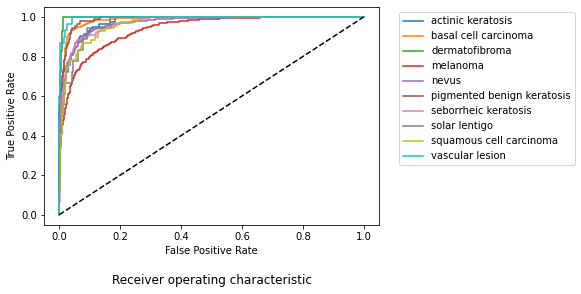

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

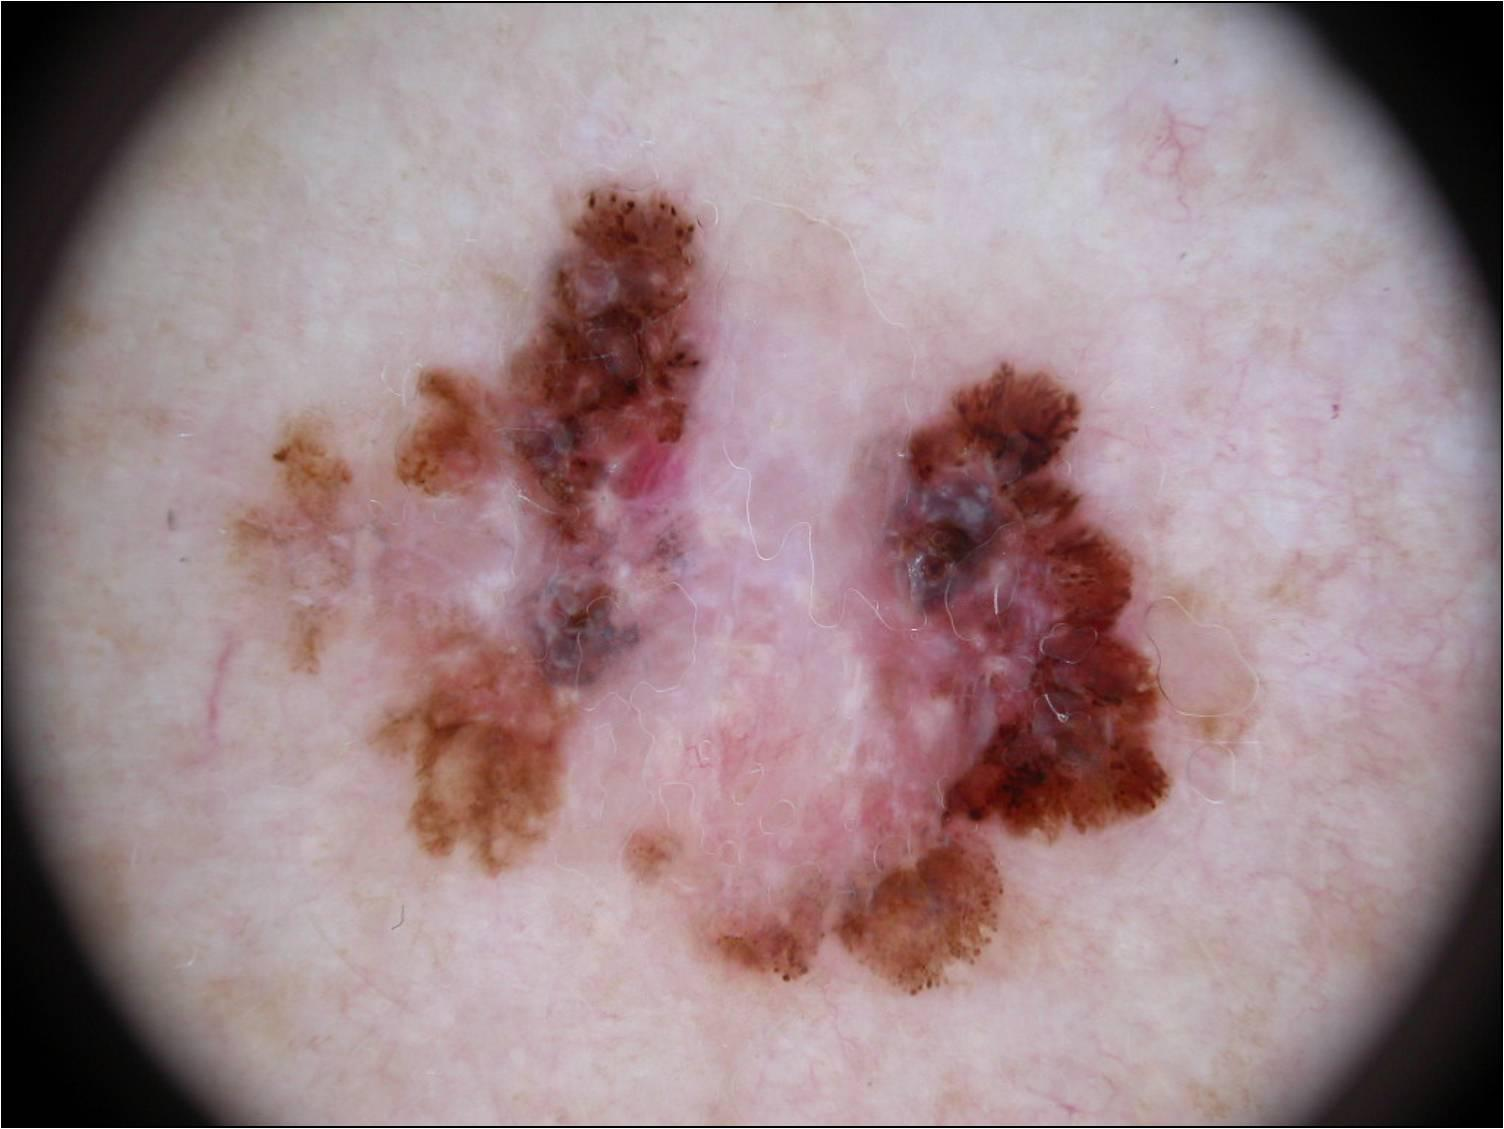

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, RETRAINABLE_LAYERS[-1])

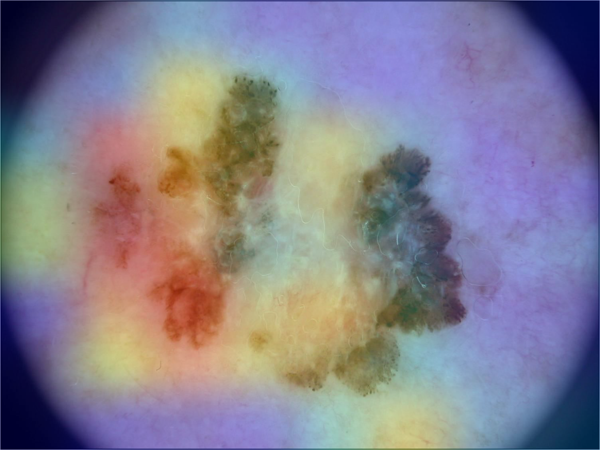

In [23]:
display_gradcam(melanoma_im_path, heatmap)